In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [2]:
import logging
from pathlib import Path

import altair as alt
import holoviews as hv
import hvplot.polars  # noqa
import numpy as np
import polars as pl
from polars import col

from src.data.database_manager import DatabaseManager
from src.features.eda import detrend_tonic_component
from src.features.scaling import scale_min_max
from src.features.utils import to_describe
from src.log_config import configure_logging
from src.plots.correlations import (
    aggregate_correlations_fisher_z,
    calculate_correlations_by_trial,
    plot_correlations_by_participant,
    plot_correlations_by_trial,
    plot_max_correlations_by_participant,
)

logger = logging.getLogger(__name__.rsplit(".", maxsplit=1)[-1])
configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado", "param", "numba"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

In [3]:
db = DatabaseManager()
with db:
    df = db.get_table(
        "Merged_and_Labeled_Data",
        exclude_trials_with_measurement_problems=True,
    )

# Add detrended EDA
# different paradigms: statistics and statistical learning / non-causal and causal
df = detrend_tonic_component(df)

# Rename columns
df = df.drop(["heart_rate", "pupil"]).rename(
    {
        "rating": "pain_rating",
        # NOTE: using the non-causal data columns here
        "heart_rate_exploratory": "heart_rate",
        "pupil_exploratory": "pupil_diameter",
        # eda tonic and phasic are already non-causally transformed
    }
)

In [4]:
# Remove first 20 seconds
df = df.filter(col("normalized_timestamp") >= 20 * 1000)
# [ 5  9 14 20 26 27 30 31 40]
# df = df.filter(col("participant_id").is_in([5, 9, 14, 20, 26, 27, 30, 31, 40]))

In [5]:
scale_min_max(df).hvplot(
    x="timestamp",
    y=[
        "eda_raw",
        "eda_phasic",
        "eda_tonic",
        # "pupil",
        # "rating",
        "temperature",
        # "pupil_r_raw",
        # "pupil_l_raw",
    ],
    groupby=["participant_id", "trial_number"],
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'d68f2206-45bd-4b4e-a26d-8d610c72e3c0': {'version…

# Temperature

In [6]:
COLORS = {
    "temperature_pain_rating_corr": "#1f77b4",
    "temperature_pupil_diameter_corr": "#ff7f0e",
    "temperature_eda_tonic_corr": "#d62728",
    "temperature_eda_phasic_corr": "#8a2be2",
    "temperature_heart_rate_corr": "#2ca02c",
}


## Temperature / Rating

In [7]:
col1, col2 = "temperature", "pain_rating"

corr_by_trial = calculate_correlations_by_trial(df, col1, col2)
corr_by_participant = aggregate_correlations_fisher_z(
    corr_by_trial, col1, col2, "participant_id", include_ci=True
)
plot_correlations_by_trial(corr_by_trial, col1, col2)
rating = plot_correlations_by_participant(
    corr_by_participant, col1, col2, with_config=False
)
rating


alt.LayerChart(...)

In [8]:
corr_by_participant.describe()

statistic,participant_id,participant_id_temperature_pain_rating_corr_mean,participant_id_temperature_pain_rating_corr_ci_lower,participant_id_temperature_pain_rating_corr_ci_upper
str,f64,f64,f64,f64
"""count""",42.0,42.0,42.0,42.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",21.5,0.775713,0.739026,0.807456
"""std""",12.267844,0.045116,0.054968,0.038745
"""min""",1.0,0.686459,0.627146,0.725711
"""25%""",11.0,0.744626,0.700885,0.786013
"""50%""",22.0,0.787325,0.752075,0.814521
"""75%""",32.0,0.80805,0.776999,0.830903
"""max""",42.0,0.867533,0.853177,0.880576


## Temperature / Pupil

In [9]:
col1, col2 = "temperature", "pupil_diameter"

corr_by_trial = calculate_correlations_by_trial(df, col1, col2)
corr_by_participant = aggregate_correlations_fisher_z(
    corr_by_trial, col1, col2, "participant_id", include_ci=True
)
plot_correlations_by_trial(corr_by_trial, col1, col2)
pupil = plot_correlations_by_participant(
    corr_by_participant, col1, col2, with_config=-False, color_map=COLORS
)
pupil

alt.LayerChart(...)

In [10]:
corr_by_participant.describe()

statistic,participant_id,participant_id_temperature_pupil_diameter_corr_mean,participant_id_temperature_pupil_diameter_corr_ci_lower,participant_id_temperature_pupil_diameter_corr_ci_upper
str,f64,f64,f64,f64
"""count""",42.0,42.0,42.0,42.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",21.5,0.26357,0.147719,0.372418
"""std""",12.267844,0.210145,0.22461,0.19693
"""min""",1.0,-0.174514,-0.278513,-0.118857
"""25%""",11.0,0.125258,-0.009725,0.256528
"""50%""",22.0,0.280388,0.145873,0.412657
"""75%""",32.0,0.447849,0.322228,0.548107
"""max""",42.0,0.631317,0.546054,0.703635


## Temperature / EDA Tonic

In [11]:
# Note that correlation values are slightly higher if we'd used detrended EDA tonic
# components (see eda.py)
# EDA tonic detrended > EDA tonic > EDA raw > EDA phasic
col1, col2 = "temperature", "eda_tonic"

corr_by_trial = calculate_correlations_by_trial(df, col1, col2)
corr_by_participant = aggregate_correlations_fisher_z(
    corr_by_trial, col1, col2, "participant_id", include_ci=True
)
# plot_correlations_by_trial(corr_by_trial, col1, col2)
eda_tonic = plot_correlations_by_participant(
    corr_by_participant, col1, col2, with_config=-False, color_map=COLORS
)
eda_tonic


alt.LayerChart(...)

In [12]:
corr_by_participant.describe()

statistic,participant_id,participant_id_temperature_eda_tonic_corr_mean,participant_id_temperature_eda_tonic_corr_ci_lower,participant_id_temperature_eda_tonic_corr_ci_upper
str,f64,f64,f64,f64
"""count""",42.0,42.0,42.0,42.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",21.5,0.216795,0.086044,0.338928
"""std""",12.267844,0.207387,0.208802,0.202433
"""min""",1.0,-0.094434,-0.203011,0.016438
"""25%""",11.0,0.051318,-0.078004,0.159491
"""50%""",22.0,0.156169,0.040391,0.319127
"""75%""",32.0,0.373497,0.229845,0.501141
"""max""",42.0,0.684461,0.591577,0.761265


## Temperature / EDA Phasic

In [13]:
col1, col2 = "temperature", "eda_phasic"

corr_by_trial = calculate_correlations_by_trial(df, col1, col2)
corr_by_participant = aggregate_correlations_fisher_z(
    corr_by_trial, col1, col2, "participant_id", include_ci=True
)
# plot_correlations_by_trial(corr_by_trial, col1, col2)
eda_phasic = plot_correlations_by_participant(
    corr_by_participant, col1, col2, with_config=-False, color_map=COLORS
)
eda_phasic

alt.LayerChart(...)

In [14]:
corr_by_participant.describe()

statistic,participant_id,participant_id_temperature_eda_phasic_corr_mean,participant_id_temperature_eda_phasic_corr_ci_lower,participant_id_temperature_eda_phasic_corr_ci_upper
str,f64,f64,f64,f64
"""count""",42.0,42.0,42.0,42.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",21.5,0.07873,0.037873,0.119372
"""std""",12.267844,0.057321,0.065947,0.05117
"""min""",1.0,-0.058635,-0.134986,-0.007413
"""25%""",11.0,0.048436,-0.001593,0.088374
"""50%""",22.0,0.080869,0.044934,0.124931
"""75%""",32.0,0.114724,0.083222,0.15154
"""max""",42.0,0.189497,0.160349,0.218316


## Temperature / Heartrate

In [15]:
col1, col2 = "temperature", "heart_rate"

corr_by_trial = calculate_correlations_by_trial(df, col1, col2)
corr_by_participant = aggregate_correlations_fisher_z(
    corr_by_trial, col1, col2, "participant_id", include_ci=True
)
plot_correlations_by_trial(corr_by_trial, col1, col2)
heart_rate = plot_correlations_by_participant(
    corr_by_participant, col1, col2, with_config=-False, color_map=COLORS
)
heart_rate

alt.LayerChart(...)

In [16]:
corr_by_participant.describe()

statistic,participant_id,participant_id_temperature_heart_rate_corr_mean,participant_id_temperature_heart_rate_corr_ci_lower,participant_id_temperature_heart_rate_corr_ci_upper
str,f64,f64,f64,f64
"""count""",42.0,42.0,42.0,42.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",21.5,0.123332,0.040691,0.204308
"""std""",12.267844,0.158353,0.162882,0.153987
"""min""",1.0,-0.15432,-0.263505,-0.089084
"""25%""",11.0,-0.020627,-0.102988,0.056041
"""50%""",22.0,0.117718,0.032998,0.191113
"""75%""",32.0,0.221064,0.135918,0.302688
"""max""",42.0,0.53165,0.477921,0.581416


## Temperature / All

In [17]:
combined_chart = (
    (
        heart_rate
        + eda_tonic
        + eda_phasic
        + pupil
        + rating  # put the plot with the color_map first,
    )
    .configure_axis(
        grid=True,
    )
    .properties(
        title="Correlations with Temperature",
    )
    .configure_legend(labelFontSize=14)
)

combined_chart

alt.LayerChart(...)

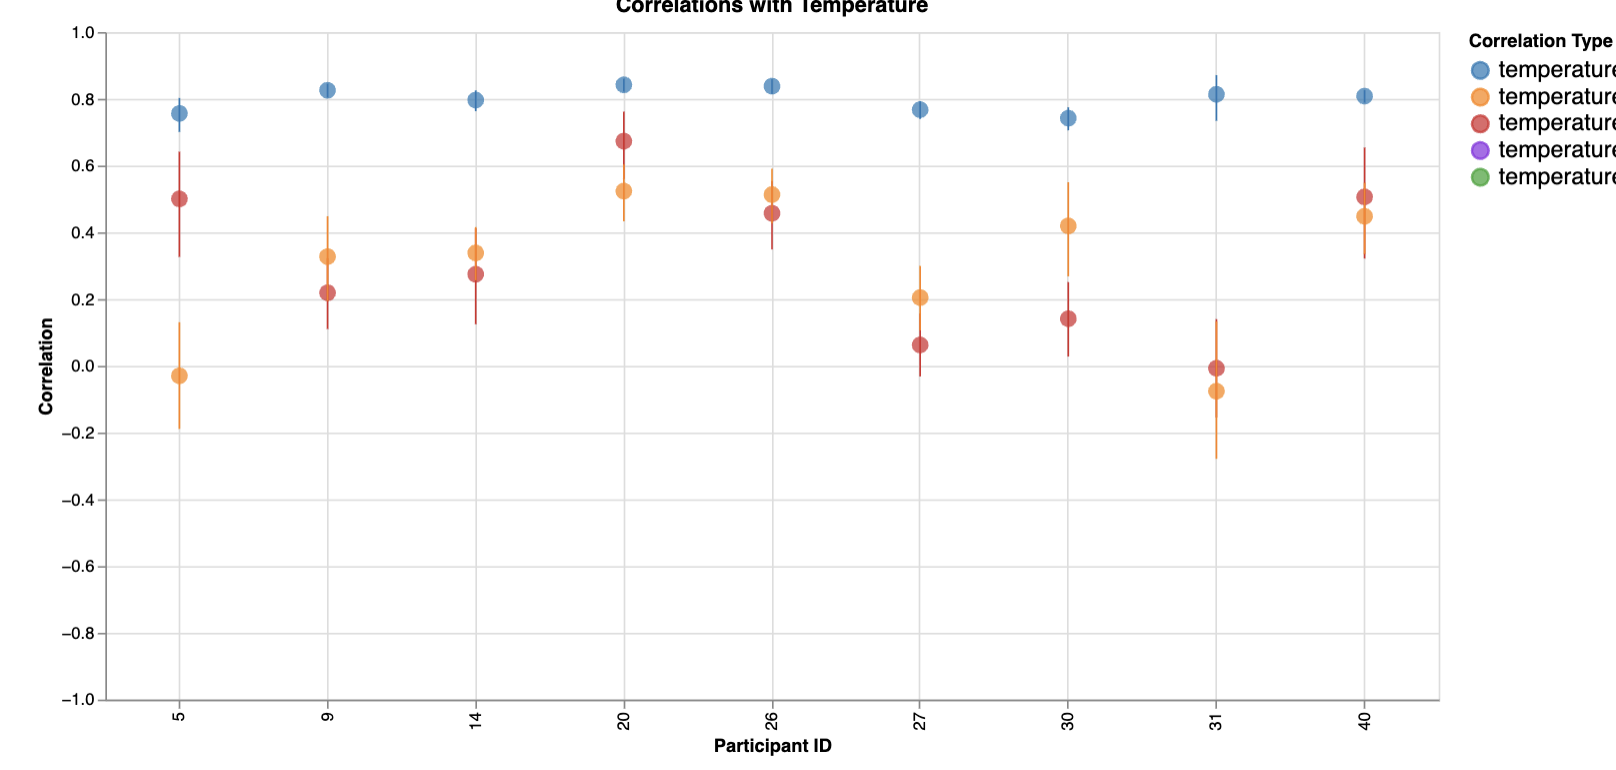

In [18]:
# Save figure
import os
from pathlib import Path

from dotenv import load_dotenv

load_dotenv()
FIGURE_DIR = Path(os.getenv("FIGURE_DIR"))


# Save the figure
path = FIGURE_DIR / "correlations_with_temperature.png"
combined_chart.save(path)
# Or save as SVG for vector graphics:
# combined_chart.save(FIGURE_DIR / "correlations_with_temperature.svg")

# Rating

In [36]:
COLORS = {
    "pain_rating_temperature_corr": "#1f77b4",
    "pain_rating_pupil_diameter_corr": "#ff7f0e",
    "pain_rating_eda_tonic_corr": "#d62728",
    "pain_rating_eda_phasic_corr": "#8a2be2",
    "pain_rating_heart_rate_corr": "#2ca02c",
}

## Rating / Temperature

In [37]:
col1, col2 = "pain_rating", "temperature"

corr_by_trial = calculate_correlations_by_trial(df, col1, col2)
corr_by_participant = aggregate_correlations_fisher_z(
    corr_by_trial, col1, col2, "participant_id", include_ci=True
)
plot_correlations_by_trial(corr_by_trial, col1, col2)
temperature = plot_correlations_by_participant(
    corr_by_participant, col1, col2, with_config=False, color_map=COLORS
)
temperature


alt.LayerChart(...)

## Rating / Pupil

In [38]:
col1, col2 = "pain_rating", "pupil_diameter"

corr_by_trial = calculate_correlations_by_trial(df, col1, col2)
corr_by_participant = aggregate_correlations_fisher_z(
    corr_by_trial, col1, col2, "participant_id", include_ci=True
)
plot_correlations_by_trial(corr_by_trial, col1, col2)
pupil = plot_correlations_by_participant(
    corr_by_participant, col1, col2, with_config=False, color_map=COLORS
)
pupil

alt.LayerChart(...)

## Rating / EDA Tonic

In [39]:
col1, col2 = "pain_rating", "eda_tonic"

corr_by_trial = calculate_correlations_by_trial(df, col1, col2)
corr_by_participant = aggregate_correlations_fisher_z(
    corr_by_trial, col1, col2, "participant_id", include_ci=True
)
plot_correlations_by_trial(corr_by_trial, col1, col2)
eda_tonic = plot_correlations_by_participant(
    corr_by_participant, col1, col2, with_config=False, color_map=COLORS
)
eda_tonic

alt.LayerChart(...)

## Rating / Phasic EDA

In [40]:
col1, col2 = "pain_rating", "eda_phasic"

corr_by_trial = calculate_correlations_by_trial(df, col1, col2)
corr_by_participant = aggregate_correlations_fisher_z(
    corr_by_trial, col1, col2, "participant_id", include_ci=True
)
plot_correlations_by_trial(corr_by_trial, col1, col2)
eda_phasic = plot_correlations_by_participant(
    corr_by_participant, col1, col2, with_config=False, color_map=COLORS
)
eda_phasic

alt.LayerChart(...)

## Rating / Heart Rate

In [41]:
col1, col2 = "pain_rating", "heart_rate"

corr_by_trial = calculate_correlations_by_trial(df, col1, col2)
corr_by_participant = aggregate_correlations_fisher_z(
    corr_by_trial, col1, col2, "participant_id", include_ci=True
)
plot_correlations_by_trial(corr_by_trial, col1, col2)
heart_rate = plot_correlations_by_participant(
    corr_by_participant, col1, col2, with_config=False, color_map=COLORS
)
heart_rate


alt.LayerChart(...)

## Rating / All

In [42]:
combined_chart = (
    (
        heart_rate
        + eda_tonic
        + eda_phasic
        + pupil
        + temperature  # put the plot with the color_map first,
    )
    .configure_axis(
        grid=True,
    )
    .properties(
        title="Correlations with Rating",
    )
    .configure_legend(labelFontSize=14)
)

# Display the chart
combined_chart


alt.LayerChart(...)

In [43]:
# Save figure
import os
from pathlib import Path

from dotenv import load_dotenv

load_dotenv()
FIGURE_DIR = Path(os.getenv("FIGURE_DIR"))


# Save the figure
path = FIGURE_DIR / "correlations_with_rating.png"
combined_chart.save(path)
# Or save as SVG for vector graphics:
# combined_chart.save(FIGURE_DIR / "correlations_with_rating.svg")

# Maximum correlation values only

In [44]:
col1, col2 = "temperature", "pupil"

corr_by_trial = calculate_correlations_by_trial(df, col1, col2)
corr_by_participant = aggregate_correlations_fisher_z(
    corr_by_trial, col1, col2, "participant_id", include_ci=True
)
plot_correlations_by_trial(corr_by_trial, col1, col2)
pupil = plot_max_correlations_by_participant(
    corr_by_trial, col1, col2, with_config=-False
)
pupil

ColumnNotFoundError: pupil

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sink' <---
DF ["trial_id", "trial_number", "participant_id", "timestamp", ...]; PROJECT */35 COLUMNS

In [ ]:
pupil + heart_rate

alt.LayerChart(...)